In [1]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from ggplot import *
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import re

nltk.download('punkt')
nltk.download('stopwords')
porter = PorterStemmer()


/usr/local/lib/python3.5/dist-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Read data

In [2]:
df_train = pd.read_csv("./python/SpookyAuthorIdentification/input/train.csv")
df_test = pd.read_csv("./python/SpookyAuthorIdentification/input/test.csv")


# EDA

In [3]:
df_train.head()


,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [4]:
df_test.head()


,id,text
0,id02310,"Still, as I urged our leaving Ireland with suc..."
1,id24541,"If a fire wanted fanning, it could readily be ..."
2,id00134,And when they had broken down the frail door t...
3,id27757,While I was thinking how I should possibly man...
4,id04081,I am not sure to what limit his knowledge may ...


In [5]:
len(df_train)


19579

In [6]:
len(df_test)


8392

In [7]:
df_train.isnull().any()


id        False
text      False
author    False
dtype: bool

In [8]:
df_test.isnull().any()


id      False
text    False
dtype: bool

-> no nan

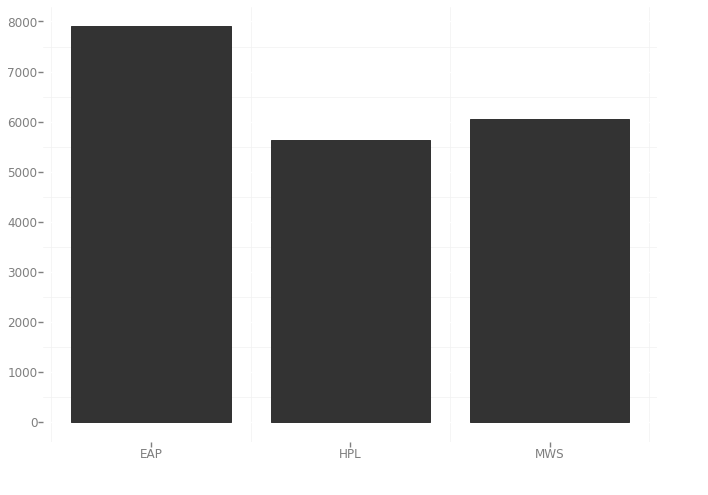

<ggplot: (-9223363307806969526)>

In [9]:
ggplot(df_train, aes(x='author')) + \
geom_bar() + \
theme_bw()


-> It's not very inballance.

In [10]:
num_graph_tokens = 100 # the number of tokens in token count graph
list_author = list(df_train['author'].drop_duplicates())


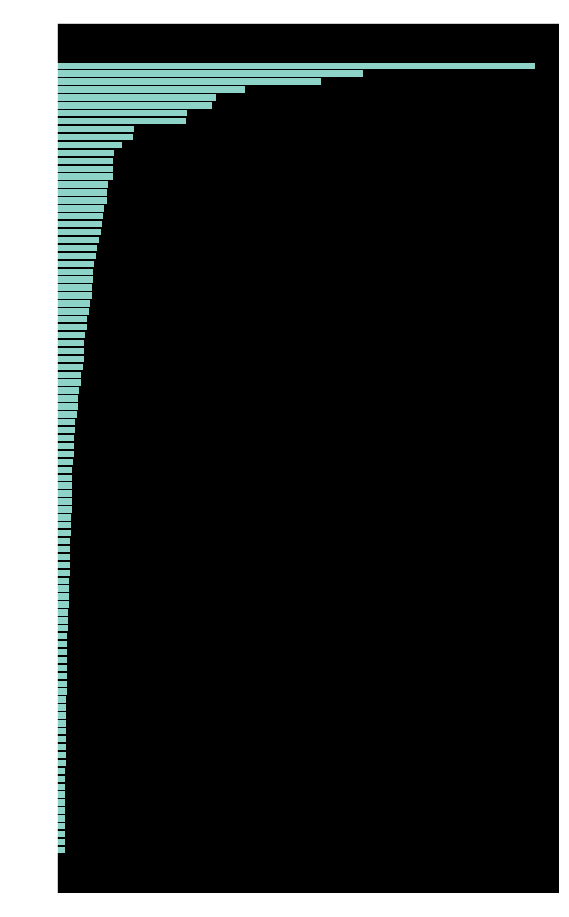

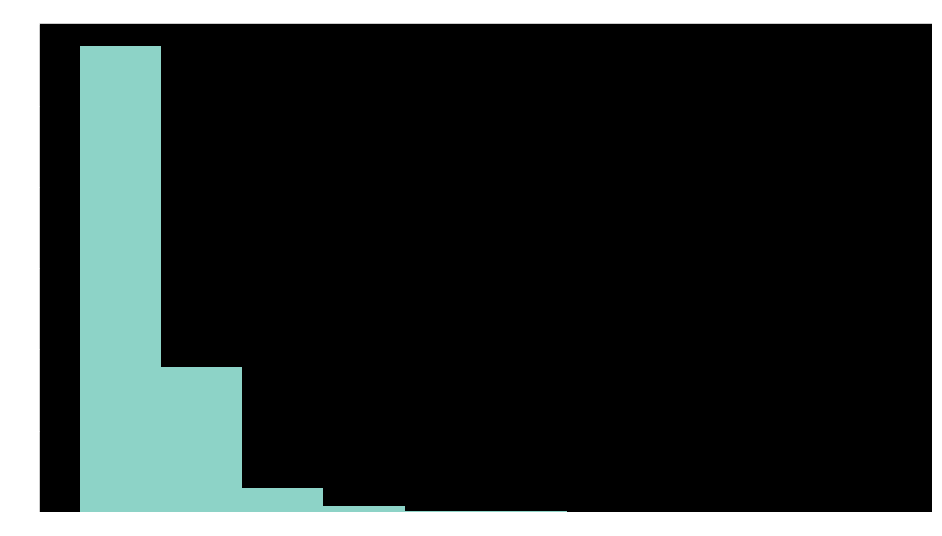

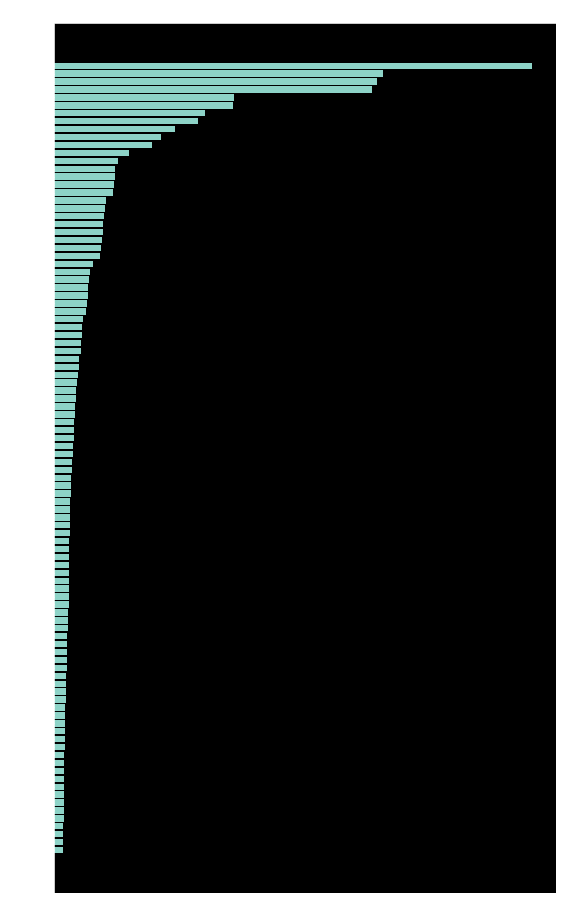

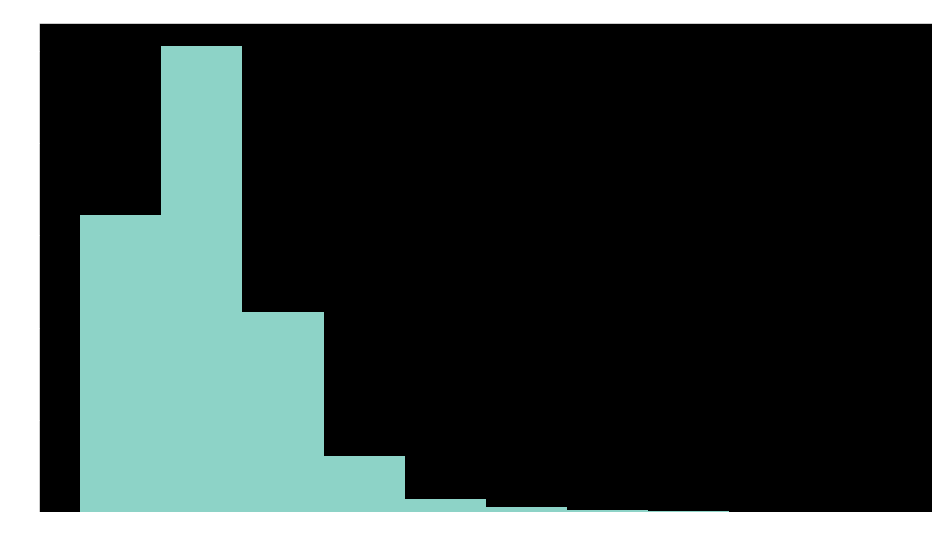

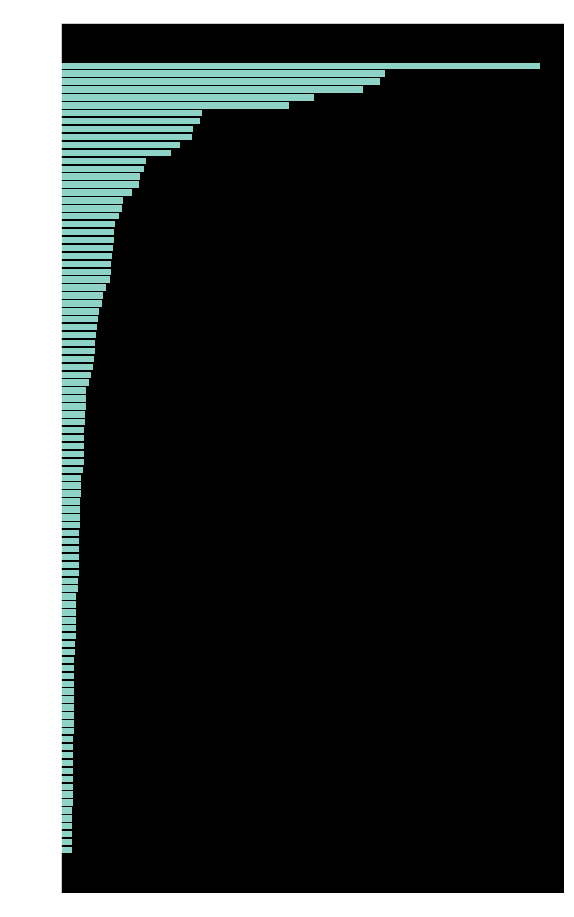

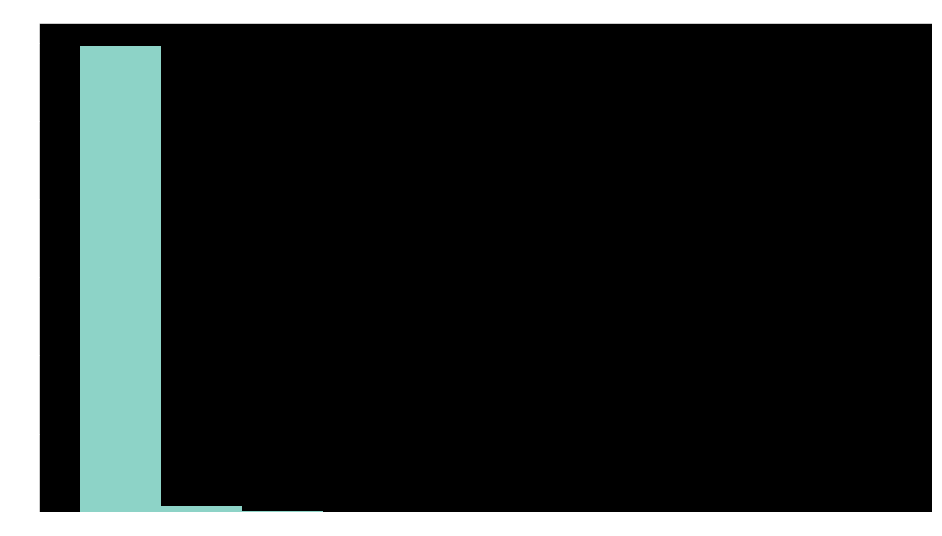

In [11]:
for author in list_author:
    # tokenize
    text_series = df_train[df_train.author == author]['text']
    token_list = [nltk.word_tokenize(text) for text in text_series]

    # concat token list
    token_all = []
    for token in token_list:
        token_all = token_all + token 
    
    # count tokens
    num_token_all = Counter(token_all)
    num_token_all = sorted(num_token_all.items(), key=lambda x: x[1],  reverse=True)
    num_token_sentence = [len(token) for token in token_list]

    # plot frequency of tokens in texts by an author
    plt.figure(figsize=(9, 16))
    plt.title(author)
    plt.barh([num_token_all[num_graph_tokens-x][0] for x in range(num_graph_tokens)], 
             [num_token_all[num_graph_tokens-x][1] for x in range(num_graph_tokens)],)

    # plot histogram of the number of tokens in  a sentence
    plt.figure(figsize=(16, 9))
    plt.title(author)
    plt.hist(num_token_sentence)


frequency graphs -> removing stop words might work
There are sentences including huge size of tokens in MWS.

# Preprocessing for natural language
define function

In [12]:
# cleansing (no use)
def cleansing_text(text):
    # remove punctuation
    dst = re.sub(r'[^\w\s]','',text) 
    dst = dst.lower() 
    return dst

# stop words removal (no use)
def remove_stopwords(text):
    stop = stopwords.words('english')
    return [word for word in text if word not in stop]

# tokenize
def tokenizer(text):
    return text.split()

# tokenize & steming by porter algorithm
def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]



# Modeling

In [13]:
lr_tfidf = Pipeline([('vect',  TfidfVectorizer()),
                     ('clf', LogisticRegression(random_state=0))])

# grid search paramete
param_grid = [{ 'vect__stop_words': [stopwords.words('english'), None],
                'vect__tokenizer': [tokenizer, tokenizer_porter],
                'clf__penalty': ['l1', 'l2'],
                'clf__C': [1, 10, 100]},
               {'vect__stop_words': [stopwords.words('english'), None],
                'vect__tokenizer': [tokenizer, tokenizer_porter],
                'vect__use_idf': [False],
                'vect__norm': [None],
                'clf__penalty': ['l1', 'l2'],
                'clf__C': [1, 10, 100]}]

gs_lr_tfidf = GridSearchCV(lr_tfidf,
                            param_grid,
                            scoring='accuracy',
                            cv=4,
                            verbose=1,
                            n_jobs=-1)

X_train = df_train.loc[:, 'text']
y_train = df_train.loc[:, 'author']
gs_lr_tfidf.fit(X_train, y_train)


Fitting 4 folds for each of 48 candidates, totalling 192 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.5min


[Parallel(n_jobs=-1)]: Done 192 out of 192 | elapsed: 16.3min finished


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
...e, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'clf__C': [1, 10, 100], 'clf__penalty': ['l1', 'l2'], 'vect__stop_words': [['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers',...', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"], None]}],
       pre_dispatch='2*n_jobs', refit=T

# Evaluate model & prediction

In [14]:
print(gs_lr_tfidf.best_score_)
print(gs_lr_tfidf.best_params_)


0.8133203943000153
{'clf__C': 10, 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer_porter at 0x7f063947e598>, 'clf__penalty': 'l2'}


In [15]:
clf = gs_lr_tfidf.best_estimator_
X_test = df_test.loc[:, 'text']
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)

df_pred = pd.DataFrame({'id': df_test.loc[:, 'id'], 
                        'EAP': [x[0] for x in y_pred_prob],
                        'HPL': [x[1] for x in y_pred_prob],
                        'MWS': [x[2] for x in y_pred_prob]},
                        columns=['id', 'EAP', 'HPL', 'MWS'])


In [16]:
# output
df_pred.to_csv('./python/SpookyAuthorIdentification/output/submission.csv', index=False)

